# CSCI 3202, Spring 2018

# Friday 2 February 2018

# In-class notebook:  Search and decision-making

<a id='top'></a>

<br>

### Your name(s): Sam Leon

<br>

* When you submit this to Moodle (under Quizlet 3), be sure to include all of your group members' names.
* You may work in groups of up to 3 people,
* but **all people** in the group must submit the assignment on their own Moodle account (because Moodle is a pain in the ass to create groups and this will still be faster than your normal quizlets).
* There are two unrelated problems. It does not matter in which order you tackle them.
  * Problem 1:  Roomba Agents.  We will code up an increasingly realistic Roomba AI. (Problem 0 is the set up)
  * Problem 2:  Decision Analysis.  We will have a close look at a seemingly trivial decision.

---

Shortcuts:  [Top](#top) || [0](#p0) || [1](#p1) | [1a](#p1a) | [1b](#p1b) | [1c](#p1c) | [1d](#p1d) || [2](#p2) | [2a](#p2a) | [2b](#p2b) | [2c](#p2c) | [2d](#p2d) | [2e](#p2e) | [2f](#p2f) | [2g](#p2g)

Before you begin, load the packages below (you might find they are handy)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy import stats

<br>

---

## Problem 0

<a/ id='p0'></a>

#### Set up and representing the task environment

Let's design some worlds! Specifically, we want to represent things like a brave knight searching a cave for treasure, or a puppy running around a park, or a Roomba cleaning up a messy house.

This initial part (Problem 0) is going to have a lot of text. But I swear it is worth reading through, because the next few problems will build off of this generic task environment framework.

**Final note:** Many of these problems are intentionally open-ended. Part of the point is to get some practice designing objects, specifically to represent things that are much more overtly "AI" than search algorithms. But (in my view) much more of the point is to **exercise the creative side of programming**. If there was only one answer, it wouldn't be nearly as much fun. 

<br>

First, let's set up some generic classes to represent `Environment`, `Agent` and `Thing`. We have a bunch of methods defined for an `Environment`, all based on what we imagine our needs might be for having an agent running around in the environment, picking things up (vacuuming, eating, holding,...) and putting them back down (a vacuum being full and spitting dirt back out, a puppy putting a bone down so it can drink water,...).

The first 3 methods are used to set up the environment, and populate it with things, or remove things from it:
* constructor: we feed in the dimensions of a square grid environment, and subtract 1 from each to account for the fact that Python is 0-based, but we are sending in the number of tiles in each direction. The lower-left corner of the environment is assumed to be (0,0). The environment can also have `things` and `agents` in it, so we create a list for each of those.
* `add_thing`: we want to be able to add things to the environment. Later, we will look at creating a class to represent `Thing`s.  We need as input to this a Thing and its location (Cartesian coordinates).
* `remove_thing`: we might need to remove some things from the environment. 

The next 3 methods are useful for representing agents' **sensors**. Namely, we are concerned about whether or not the agent can sense things at or near the agent.
* `things_near`: we might be interested to know what are all the things in the tiles *adjacent* to the agent's location (as well as at the agent's location), so we return this as a list.
* `things_at`: perhaps we have an agent that can only sense what is going on in its location (otherwise, the same as `things_near`)
* `percepts`: by default in this generic `Environment` class, the agents will be able to perceive anything *near* them. We can override this later depending on if we think our agent should be able to sense more or less.

We have 3 methods to represent the agent moving through a 2D rectangular grid environment, as well as executing a couple other generic **actions**.
* `hit_wall`: we know the boundaries of the environment, so if the agent tries to move outside of them, we need to let it know that it has bumped into a wall
* `move`: the agent tries to execute a move
* `execute_action`: here is the meat and cheese of the agent's actuators. In this generic class, we allow the agent to move in any of the four cardinal directions, as well as pick things up (`Grab`) and set things down (`Drop`).

Finally, we need a few more methods to define how the actual simulation for the task environment is to proceed.
* `is_done`: returns True if there are no more "living" agents to simulate
* `step`: executes a single time step of the environment: the agent senses the environment, and then acts. This method by default is assuming a single agent, but we could override this to make it more general. You will notice that the `step` method is where we print output to the screen to stay apprised of what is going on in our virtual world.
* `driver`: this is the driver method, which takes as an argument the number of time steps to run (default is 5).


In [3]:
class Environment:

    def __init__(self, width, height):
        self.width = width-1    # relative to 0, so subtract 1
        self.height = height-1
        self.things = []
        self.agents = []

    #
    # The following 2 methods allow us to add Things or remove Things from the environment
    #
    
    def add_thing(self, thing, location):
        '''Add a thing to the environment and set its location.
        For convenience, if thing is an agent program we make a new agent for it.'''
        # first, check if the desired location is in-bounds
        out_of_bounds = (location[0] > self.width or location[0] < 0 or
                         location[1] > self.height or location[1] < 0)
        if out_of_bounds:
            print('Warning: failed to add {} object at {}'.format(thing.__class__.__name__, location))
            return

        if not isinstance(thing, Thing):
            thing = Agent(thing)
        thing.location = location
        self.things.append(thing)
        if isinstance(thing, Agent):
            self.agents.append(thing)

    def remove_thing(self, thing):
        if thing in self.things:
            self.things.remove(thing)
            return True
        elif thing in self.agents:
            self.agents.remove(thing)
            return True
        else:
            return False

    #
    # The next 3 methods set up the agent's perception of things around it (SENSORS)
    #
    
    def things_near(self, location):
        '''return all things around the given location'''
        things = []
        for thing in self.things:  
            # look within a radius of 1 around the agent; on Cartesian grid, 
            # this will only return the Things at the adjacent squares
            # NOTE: if you wanted to let the agent have great vision/better sensors, this
            #       could be modified
            if np.sqrt( (thing.location[0]-location[0])**2 + (thing.location[1]-location[1])**2) <= 1:
                things.append(thing)
        return things
    
    def things_at(self, location):
        '''return all things at the given location'''
        things = []
        for thing in self.things:        
            if thing.location==location:
                things.append(thing)
        return things
    
    def percepts(self, agent):
        '''the agent can perceive things N/S/E/W of their location'''
        return self.things_near(agent.location)

    #
    # The next 3 methods set up how the agent can interact with the environment (ACTUATORS)
    #
    
    def hit_wall(self, location):
        '''hit a wall/boundary if the agent tries to go out of bounds'''
        return (location[0] > self.width or location[0] < 0 or location[1] > self.height or location[1] < 0)
        
    def move(self, agent, direction):
        '''get the new agent location, but revert to old if it bumps into boundary'''
        locx, locy = agent.location
        if direction=='N':
            newLocation = locx, locy+1    
        elif direction=='S':
            newLocation = locx, locy-1
        elif direction=='E':
            newLocation = locx+1, locy
        elif direction=='W':
            
            newLocation = locx-1, locy
        bump = self.hit_wall(newLocation)
        agent.location = newLocation if not bump else location
        return (not bump)
            
    def execute_action(self, agent, action):
        if action in ['N','S','E','W']:
            bump = self.move(agent, action)
        elif action == 'Grab':
            things = [thing for thing in self.things_at(agent.location)]
            if things:
                agent.holding.append(things[0])
                self.remove_thing(things[0])
        elif action == 'Drop':
            if agent.holding:
                dropped = agent.holding.pop()
                self.add_thing(thing=dropped, location=agent.location)

    #
    # These last 3 methods set up how the simulation for the task environment will be run
    #
    
    def is_done(self):
        '''end the simulation if there are no living agents (or end of time steps)'''
        return not any(agent.is_alive() for agent in self.agents)

    def step(self, quiet):
        '''run one time step of the environment; assumes a single agent'''
        if not self.is_done():
            # assuming a single agent here!
            agent = self.agents[0]
            action = agent.function(self.percepts(agent))
            if not quiet:
                print('Agent {} executes action {} at location {}'.format(agent.name, action, agent.location))
            self.execute_action(agent, action)

    def driver(self, n_steps=5, quiet=False):
        '''a driver method to run the environment for n_steps time steps
        quiet=True will suppress output to screen to update (helpful for long simulations)'''
        for step in range(n_steps):
            self.step(quiet)

Okay, you've made it this far. You deserve a reward.  Here's a picture of a baby sloth wearing pajamas and taking a selfie.

<img src="https://i.pinimg.com/736x/bc/4b/4c/bc4b4c4c01a6a82d8991524c9f41f6ce--pajamas-pjs.jpg" style="width: 200px;"/>


Now then. We should define some generic classes for `Thing`s and `Agent`s.  We can consider an `Agent` to be a subclass of `Thing`, since it is just a special case of general objects that we are putting in our environment.

Our generic `Thing` class is pretty sparse. Basically, we are going to throw down some objects and declare whether or not they are alive. It serves as a basis for representing other things later that we can add other useful attributes to.

In [4]:
class Thing:
    '''represent things in the environment'''
    
    def __init__(self):
        pass
        
    def is_alive(self):
        '''is this thing alive?'''
        return hasattr(self, 'alive') and self.alive

Finally, we can create an `Agent` as a subclass of `Thing`.  We should provide a **name** for our agents, and an **agent function**.  Recall that the agent function is what is "doing the AI". That is, the agent function takes as input the percepts, and provides as output the appropriate agent actions to take.

Note that in case an agent function argument is not provided, we have a nice default course of action for a listless agent. There is also an attribute of the agent to store its `performance` measure, once we decide how to evaluate that.

In [5]:
class Agent(Thing):
    
    def __init__(self, name, agent_function=None):
        self.alive = True
        self.name = name
        self.holding = []
        self.performance = 0
        if agent_function is None:
            print('Warning: Agent {} missing agent_function. Using a silly default.'.format(self.name))
            
            def agent_function(percepts):
                '''Only move left. It is the finest direction, after all.
                Note that this only is run if the user does not supply a valid agent_function'''
                return 'W'

        self.function = agent_function

<br>

---

[Back to top](#top)

<br>

<img src="http://www.irobotweb.com/-/media/Images/Product-Pages/Roomba-Learn/Mini-Compare/960-Product-Image.png?h=292&la=en&w=286" alt="Drawing" style="width: 120px;"/>

<a/ id='p1'></a>
## Problem 1:  Let's talk Roombas.

The generic `Environment`/`Thing`/`Agent` set-up above is a pretty nice framework for tackling a variety of problems, but we will need to override a few components of it to make this function well for the specific task environment of a Roomba cleaning up a dirty room.

First, let's create a **simple reflex agent**, `ReflexRoombaAgent`, method.  This function will take in an argument **name**, representing the agent's name.  Then, an `agent_function` is defined.  This is the most problem-specific part.  The `agent_function` below is specific to our simple two-tile environment that we will play around with initially.  Later, we will modify and extend this to larger rooms, and to other problems.

After defining the `agent_function`, the `ReflexRoombaAgent` constructs an `Agent` object using the generic template above, but with Roomba-specific programming (i.e., `agent_function`).

In [6]:
def ReflexRoombaAgent(name):
    '''reflex Roomba agent. Takes percept as input, which is a tuple of (location, status)
    and returns the appropriate action. This will override the default in the Agent class of 
    only moving West'''
    def agent_function(percepts):
        location, status = percepts
        if status == 'Dirty':
            return 'Vacuum'
        elif location == (0,0):
            return 'E'
        elif location == (1,0):
            return 'W'
        
    return Agent(name, agent_function)        

This Roomba is going to need some `Thing`s to clean up - namely, dirt! So let's create a subclass of `Thing` to represent dirt. If you haven't seen or used the `pass` statement in Python, it is just a placeholder when there needs to be *some*thing in that line, since Python syntax relies on whitespace. (Otherwise, we wouldn't know when to end the definition for the Dirt class.)

In [7]:
class Dirt(Thing):
    pass

Now that we have a Roomba and Dirt, specific to our vacuum task environment, let's make the `Environment` a bit more problem-specific.  The agent interacts with the environment through percepts and actuators, so we will need to override those defaults from the main Environment class. 

For `percepts`, we will assume that the agent can sense (1) its location and (2) whether that location is clean or dirty.  `percepts` takes as the argument the **agent**, and returns a tuple of (**location**, **status**).  Note that the actual "sensing" is done by the `Environment` method `things_at(location)`. That line checks whether or not any of the `things_at` the agent's location are of class Dirt. Note that it is possible to have multiple instances of Dirt in  given location, which could reflect the fact that in real life, sometimes our house is just really gross.

For actuators, the generic `execute_action` method is almost good enough. We can override the `Grab` action with something more meaningful to our application.  Let's rename that as `Vacuum`, and call the things we want to grab `messes`.

We only want the Roomba to pick up things that are Dirt (ideally), so we add the condition `if isinstance(thing, Dirt)`.  Notice that the Roomba will only pick up the *first* unit of dirt that it senses. This reflects the reality that if a tile is *really* dirty, it should take the Roomba longer to clean it up than a just mildly dirty tile.

Notice that we also store in Roomba's `holding` attribute all of the different units of dirt that it has picked up. Later, we will generalize this problem so that Roomba can only store a finite amount of dirt, which is of course how real vacuums work.

In [8]:
class VacuumEnvironment(Environment):
            
    def percepts(self, agent):
        ''' the percept is a tuple of (location, status) '''
        status = 'Dirty' if any([isinstance(item, Dirt) 
                                 for item in room.things_at(location=agent.location)]) else 'Clean'
        return (agent.location, status)

    def execute_action(self, agent, action):
        ''' override the default execute_action in Environment class, so that
        for the Roomba we remove '''
        if action in ['N','S','E','W']:
            bump = self.move(agent, action)
        elif action == 'Vacuum':
            messes = [thing for thing in room.things_at(roomba.location) if isinstance(thing, Dirt)]
            if messes:
                agent.holding.append(messes[0])
                self.remove_thing(messes[0])
        elif action == 'Drop':
            if agent.holding:
                dropped = agent.holding.pop()
                self.add_thing(thing=dropped, location=agent.location)

<br>

<a/ id='p1a'></a>
### (1a)

#### Enough chit chat. Play time!

Create a **room** that is a `VacuumEnvironment` with width=2 and height=1 (i.e., the standard two-tile room from the introductory set of slides where we introduced the concept of agents). Notice that the Cartesian coordinates of the tiles are (0,0) and (1,0), for a width of 2 and height of 1.

In [348]:
room = VacuumEnvironment(width=2, height=1)

If we have a room, and that room can get dirty, we should probably instantiate a `ReflexRoombaAgent`.  Since our `ReflexRoombaAgent` is of class `Agent`, which is a subclass of `Thing`, we will need to use the `add_thing` method to add our Roomba to the **room**.  Here, you can see that we are adding the Roomba to the tile at (0,0).

**Most importantly:** Give your Roomba a sweet name.

In [349]:
roomba = ReflexRoombaAgent('Randy')
room.add_thing(roomba, location=(0,0))

Finally, to set up the environment, let's sprinkle some dirt around.  In fact, let's set it up so that both tiles are `Dirty`.

In [350]:
room.add_thing(Dirt(), location=(0,0))
room.add_thing(Dirt(), location=(1,0))

At long last, we are ready to actually run our simulation.  Let's run for 6 time steps.

In [351]:
room.driver(6)

Agent Randy executes action Vacuum at location (0, 0)
Agent Randy executes action E at location (0, 0)
Agent Randy executes action Vacuum at location (1, 0)
Agent Randy executes action W at location (1, 0)
Agent Randy executes action E at location (0, 0)
Agent Randy executes action W at location (1, 0)


Okay, that looks like it went smoothly.  We should check that everything is working though.  After 6 time steps, the Roomba should have been able to vacuum up the patches of dirt in both tiles.  Then, what does the agent do? Check out the `agent_function` definition to make sure that, after the agent vacuums up all the dirt, it does what you expect.

We can also check to make sure the list of things in the room, and the list of what all the Roomba agent is holding, both match our expectations.  What should be left in the room?  What should Roomba be holding?  Design a couple `print` statements to check that our task environment looks the way we expect.

In [352]:
print('Things left in the room: {}'.format([thing.__class__.__name__ for thing in room.things]))
print('Things agent is holding: {}'.format([thing.__class__.__name__ for thing in roomba.holding]))

Things left in the room: ['Agent']
Things agent is holding: ['Dirt', 'Dirt']


<br>

Now that we have a basic Roomba agent in a very simple room, let's start to add in layers of complexity/reality. Each part of the rest of this problem adds another feature or set of features to make our Roomba Agents a bit more like actual Roombas.  By the end of this problem, our "toy" Roombas will be pretty similar to actual Roombas.

For the next few parts, my approach would be to only modify the Roomba-specific programming from **Problem 1** and beyond; try to leave the stuff in **Problem 0** alone, if you can. The point of the `ReflexRoombaAgent` and `VacuumEnvironment` classes is to take the generic `Agent` and `Environment` classes and apply vacuum-specific methods, as opposed to hard-coding the entire gory mess from (e.g.) the `Environment` class in **Problem 0**. So, instead of jumping back and forth to modify the codes from **1a**, the easiest thing to do to implement these additional code features is probably to begin by copy-pasting, but then giving the new subclasses here new names.


<br>

<a/ id='p1b'></a>
### (1b)

Also implement the following features. It is probably easiest to do these **one at a time**, to make sure you know which breaks your code if things go off the rails.
1. Include a performance measure for the agent to keep track of.  You should decide for yourselves how you want to measure your Roomba's performance. Here are some general guidelines:
  * ~~Reward cleanliness~~
  * ~~Penalize excessive moving around~~
1. Implement a model-based agent
  * Keep track of which tiles are clean/dirty
  * Perhaps use an attribute of the agent called **model** that updates the agent's internal map of where the clean/dirty tiles all are. The entire room is initially unknown.
  * For example, if the Roomba agent has just come from cleaning the tile at (0,0), and has now just cleaned the tile at (1,0), then the Roomba ought to know that going straight back to (0,0) is not the best option.
  * You may want to add a **NoOp** ("no operation" or "do nothing") action choice, since moving around unnecessarily will worsen the agent's performance measure.
1. Stochastically generate new dirt every so often
  * Based on how long it has been since the agent last cleaned a particular tile, it may be necessary to circle back around and check the tiles again for dirt (since it may have appeared stochastically). Thus, the agent will need to track in its model *how long* it has been since it has cleaned each tile.
  * It may be useful to print a message to the screen denoting the location of new dirt, if dirt appears somewhere.

The following code snippet could implement stochastic dirt appearance with probability `p_dirt` for each tile for each time step.  You are encouraged to modify `p_dirt` as you see fit.  The default here is a 1/10 probability of dirt appearing on any given tile at any given time step, possibly from a puppy with muddy paws or a roommate just returning from a hike.  Note that *all* tiles will need to be updated in this way, and that `p_dirt` is probably most appropriate to specify as an attribute of the environment.

In [534]:
class Agent(Thing):
    
    def __init__(self, name, agent_function=None):
        self.alive = True
        self.name = name
        self.holding = []
        self.performance = 0
        self.clean_tiles = []
        self.timer = 0
        self.e_timer = 0
        self.current_moves = []
        self.walls = []
        self.critical = False
        self.criticalTimer = 0
        if agent_function is None:
            print('Warning: Agent {} missing agent_function. Using a silly default.'.format(self.name))
            
            def agent_function(percepts):
                '''Only move left. It is the finest direction, after all.
                Note that this only is run if the user does not supply a valid agent_function'''
                return 'W'

        self.function = agent_function
        
    def add_clean_tile(self, location):
        self.clean_tiles.append(location)
        
    def remove_tiles(self, location):
        if location in self.clean_tiles:
            self.clean_tiles.remove(location)
            
        
        
def ModelRoombaAgent(name, agent):
    '''reflex Roomba agent. Takes percept as input, which is a tuple of (location, status)
    and returns the appropriate action. This will override the default in the Agent class of 
    only moving West'''
    if agent == None:
        return Agent(name, None)
    
    def agent_function(percepts):
        location, status = percepts
        '''Timer resets every 3 steps, so we recheck if tiles are clean'''
        if agent.timer == 3: #Timer to keep track of how long it's been since we've check for cleanness
            agent.clean_tiles = []
            agent.timer = 0
            #print('Wiping--remaining list:{}'.format(agent.clean_tiles))
        agent.timer += 1
        if status == 'Clean':
            if location not in agent.clean_tiles:
                #print('{} clean. Appending...{}'.format(location, agent.clean_tiles))
                agent.clean_tiles.append(location)
                agent.performance += 5
        if status == 'Dirty':
            agent.clean_tiles.append(location)
            return 'Vacuum'
        elif location == (0,0):
            if (1,0) in agent.clean_tiles:
                #print('Already visited (1,0), doing nothing!')
                agent.performance += 5
                return
            #print('(1,0) not yet visited, moving East- {}'.format(agent.clean_tiles))
            return 'E'
        elif location == (1,0):
            if (0,0) in agent.clean_tiles:
                agent.performance += 5
                #print('Already visited (1,0), doing nothing!')
                return
            #print('(0,0) not yet visited, moving West- {}'.format(agent.clean_tiles))
            return 'W'
    return Agent(name, agent_function)           

class MyEnvironment(Environment):
    def percepts(self, agent):
        ''' the percept is a tuple of (location, status) '''
        status = 'Dirty' if any([isinstance(item, Dirt) 
                                 for item in room.things_at(location=agent.location)]) else 'Clean'
        return (agent.location, status)

    def execute_action(self, agent, action):
        ''' override the default execute_action in Environment class, so that
        for the Roomba we remove '''
        agent.e_timer += 1
        if agent.e_timer == 5:
            agent.e_timer = 0 
            for i in range(self.width+1):
                for j in range(self.height+1):
                    p_dirt = 0.0
                    updateStatus = np.random.choice(['Clean','Dirty'], p=[1-p_dirt, p_dirt])
                    #print('Update status: {}'.format(updateStatus))
                    if updateStatus == 'Dirty':
                        location = (i, j)
                        print('Adding dirt at: {}'.format(location))
                        self.add_thing(Dirt(), location)
        if action in ['N','S','E','W']:
            agent.performance -= 1
            bump = self.move(agent, action)
        elif action == 'Vacuum':
            agent.performance += 5
            messes = [thing for thing in room.things_at(roomba.location) if isinstance(thing, Dirt)]
            if messes:
                agent.holding.append(messes[0])
                self.remove_thing(messes[0])
        elif action == 'Drop':
            if agent.holding:
                dropped = agent.holding.pop()
                self.add_thing(thing=dropped, location=agent.location)


In [535]:
def run_sims(trials, agent):
    for i in range(trials):
        room = MyEnvironment(width=2, height=1)
        roomba = agent
        #roomba = ModelRoombaAgent('Randy', None)
        roomba = ModelRoombaAgent('Randy', roomba)
        
        room.add_thing(roomba, location=(0,0))
        room.add_thing(Dirt(), location=(0,0))
        room.add_thing(Dirt(), location=(1,0))
        room.driver(10, True)

        print("{}'s performance score: {}".format(roomba.name, roomba.performance))
        print('Things left in the room: {}'.format([thing.__class__.__name__ for thing in room.things]))
        print('Things agent is holding: {}'.format([thing.__class__.__name__ for thing in roomba.holding]))
        
run_sims(10, roomba)

Randy's performance score: -4
Things left in the room: ['Agent', 'Dirt', 'Dirt']
Things agent is holding: []
Randy's performance score: -3
Things left in the room: ['Agent', 'Dirt', 'Dirt']
Things agent is holding: []
Randy's performance score: -3
Things left in the room: ['Agent', 'Dirt', 'Dirt']
Things agent is holding: []
Randy's performance score: -4
Things left in the room: ['Agent', 'Dirt', 'Dirt']
Things agent is holding: []
Randy's performance score: -3
Things left in the room: ['Agent', 'Dirt', 'Dirt']
Things agent is holding: []
Randy's performance score: -3
Things left in the room: ['Agent', 'Dirt', 'Dirt']
Things agent is holding: []
Randy's performance score: -4
Things left in the room: ['Agent', 'Dirt', 'Dirt']
Things agent is holding: []
Randy's performance score: -3
Things left in the room: ['Agent', 'Dirt', 'Dirt']
Things agent is holding: []
Randy's performance score: -3
Things left in the room: ['Agent', 'Dirt', 'Dirt']
Things agent is holding: []
Randy's performance

There should be a relationship between the agent's performance, the frequency with which new dirt stochastically appears (`p_dirt`), and your `NoOp` action strategy (which avoids excessive moving around).  This might be easiest to think about in terms of the limiting cases:
* What should be the agent's `NoOp` strategy if `p_dirt` = 1?
* What should be the agent's `NoOp` strategy if `p_dirt` = 0?

Note that we don't have any control over `p_dirt`; it is a property of how filthy our living conditions are. All we can do is specify the Roomba's `NoOp` strategy (waiting time before circling back to check for new dirt) as best we can.

So, try a few very long simulations (you might want to suppress the printed output for these) with different combinations of `NoOp` strategy and `p_dirt` values.  For a couple different values of `p_dirt`, what do you find to be the optimal `NoOp` strategies? That is, what waiting time (once the agent knows it has cleaned everything) will maximize the agent's performance?

Every three "environment steps" seems to output the best performance. However, this is completely dependent on how clean the room is. 

<br>

<a/ id='p1c'></a>

### (1c)

Let's continue to build this up! We can make things a bit more interesting by increasing the size of the room. Add the following features to your codes from **(1b)**:
* ~~Try a 2x2 room first.~~
* In the example codes, Roomba knew the geography of the environment (i.e., that it is a 2x1 room), so it knew the options for moving around.
  * ~~As a first attempt for your 2x2 room, make this assumption.  Thus, the Roomba's choices of action to execute will depend on its sensed location.~~
    * Note that if Roomba is at (0,0), and senses that this tile is clean, but has no information about (1,0) or (0,1), then it should choose at random where to go next. A modification of the `np.random.choice` function call above can take care of this.
  * Once that seems to work, try to incorporate the fact that the Roomba typically does not know a priori what the shape of the room is. 
    * The easiest first step to build this into your model is to have Roomba sense its environment: if dirty, then clean the tile; if clean, then move randomly. (This is how I clean my apartment.)
    * Then you can try building a **map** of the room as part of the Roomba's model. So as the random-movement Roomba flails around, it will sometimes bump into a wall.  But if it senses a bump, then Roomba can *learn* where the walls are, and what the available actions are depending on where in the room it is.
    * Holy heck, we just built a *learning* model-based agent!
* Once your Roomba is successfully tidying up a 2x1 or 2x2 room, go bigger!
* It might be useful to note that the only thing that really needs to change is your `agent_function`, which maps percepts to actions. The `VacuumEnvironment` class is already able to handle arbitrary-sized rooms. So selecting an action will need to be modified, as well as how the agent builds its internal model of the task environment.

In [536]:
def ModelRoombaAgent(name, agent):
    '''reflex Roomba agent. Takes percept as input, which is a tuple of (location, status)
    and returns the appropriate action. This will override the default in the Agent class of 
    only moving West'''
    if agent == None:
        return Agent(name, None)
    
    def agent_function(percepts):
        location, status = percepts
        '''Timer resets every 3 steps, so we recheck if tiles are clean'''
        if agent.timer >= 6:
            agent.critical = True
            agent.criticalTimer += 1
        if agent.timer == 10: #Timer to keep track of how long it's been since we've check for cleanness
            agent.clean_tiles = []
            agent.timer = 0
            
        if agent.critical == True or len(agent.holding) >= 2:
            locx, locy = location
            if 0 > locx:
                if room.hit_wall((locx-1, locy)) == False:
                    return 'W'
            if 0 < locx:
                if room.hit_wall((locx+1, locy)) == False:
                    return 'E'
            if 0 > locy:
                if room.hit_wall((locx, locy+1)) == False:
                    return 'N'
            if 0 < locy:
                if room.hit_wall((locx, locy-1)) == False:
                    return 'S'
            if (0,0) == location:
                agent.critical = False
                agent.criticalTimer = 0
                return 'Drop'
            if agent.criticalTimer == 6:
                agent.alive = False
                print('You lose')
                agent.critical = False
            
        agent.timer += 1
        if status == 'Clean':
            if location not in agent.clean_tiles:
                agent.clean_tiles.append(location)
                agent.performance += 5
        if status == 'Dirty':
            agent.clean_tiles.append(location)
            return 'Vacuum'
        locx, locy = location
        if room.hit_wall((locx-1, locy)) == False: 
            if(locx-1, locy) not in agent.clean_tiles: 
                agent.current_moves.append('W')
        if room.hit_wall((locx-1, locy)) == True:
            if (locx-1, locy) not in agent.walls:
                    agent.walls.append((locx-1, locy))
        ##################################
        if room.hit_wall((locx, locy+1)) == False: 
            if (locx, locy+1) not in agent.clean_tiles: 
                agent.current_moves.append('N')
        if room.hit_wall((locx, locy+1)) == True:
            if (locx, locy+1) not in agent.walls:
                    agent.walls.append((locx, locy+1))
        ##################################
        if room.hit_wall((locx+1, locy)) == False: 
            if(locx+1, locy) not in agent.clean_tiles: 
                agent.current_moves.append('E')
        if room.hit_wall((locx+1, locy)) == True:
            if (locx+1, locy) not in agent.walls:
                    agent.walls.append((locx+1, locy))
        ##################################
        if room.hit_wall((locx, locy-1)) == False: 
            if(locx, locy-1) not in agent.clean_tiles: 
                agent.current_moves.append('S')
        if room.hit_wall((locx, locy-1)) == True:
            if (locx, locy-1) not in agent.walls:
                    agent.walls.append((locx, locy-1))
        if agent.current_moves == []:
            return
        choice = np.random.choice(agent.current_moves)
        agent.current_moves = []
        return choice
    return Agent(name, agent_function)         

In [541]:
room = MyEnvironment(width=2, height=2)
roomba = ModelRoombaAgent('Randy', roomba)
roomba = ModelRoombaAgent('Randy', roomba)

room.add_thing(roomba, location=(0,0))
room.add_thing(Dirt(), location=(0,0))
room.add_thing(Dirt(), location=(1,0))
room.add_thing(Dirt(), location=(0,1))
room.add_thing(Dirt(), location=(1,1))
room.driver(10)

print("{}'s performance score: {}".format(roomba.name, roomba.performance))
print('Things left in the room: {}'.format([thing.__class__.__name__ for thing in room.things]))
print('Things agent is holding: {}'.format([thing.__class__.__name__ for thing in roomba.holding]))

Agent Randy executes action Vacuum at location (0, 0)
Agent Randy executes action E at location (0, 0)
Agent Randy executes action Vacuum at location (1, 0)
Agent Randy executes action N at location (1, 0)
Agent Randy executes action Vacuum at location (1, 1)
Agent Randy executes action W at location (1, 1)
Agent Randy executes action S at location (0, 1)
Agent Randy executes action Drop at location (0, 0)
Agent Randy executes action Drop at location (0, 0)
Agent Randy executes action Drop at location (0, 0)
Randy's performance score: 11
Things left in the room: ['Agent', 'Dirt', 'Dirt', 'Dirt', 'Dirt']
Things agent is holding: []


<br>

<a/ id='p1d'></a>

### (1d)

Let's add two more related details that will really make this Roomba more realistic.
* Roombas have a certain amount of **charge**, which depletes as time goes on. You could incorporate this into the model in a few different ways. Use your ingenuity and creativity to decide how to implement this! If you get stuck, ask other groups or ask me.
  * This means that your Roomba is going to need a particular location as a charging spot, and should return to it every so often.
  * It is probably reasonable to assume that your Roomba knows how long (how many time steps) it takes to deplete its battery. As part of Roomba's model, it should keep track of how long it will take to return to the charging port and how much battery life remains.
  * If the battery falls below a critical point, return to base!
  * What should happen if the battery is fully depleted?
* Roombas also can only hold a **finite amount of dirt**.
  * If the dirt gets "full" (you will need to implement some dirt limit as part of the agent), then the Roomba can't vacuum anymore and needs to return to the charging port to dump its dirt.

<br>

---

[Back to top](#top)

<img src="https://i.pinimg.com/736x/ca/0d/9f/ca0d9f851e6c21b737883eecc5083250.jpg" alt="Drawing" style="width: 180px;"/>


<a id='p2'></a>

## Problem 2

### Decision analysis: A Boulder-ific Example

<a id='p2a'></a>
### (2a)

Suppose a total (including you) of $n=12$ of your friends are planning to have a ski weekend in Steamboat Springs. The condo you will rent costs \$240 per night, and there is a 3-night minimum stay.  Now suppose all 12 people are positive that they will stay for Friday and Saturday night. But some of the gang are slackers who don't have class until 4 PM on Monday, and they want to stick around for another half-day of skiing.  The decision we are going to analyze is this:  **how should we split up the cost among the 12 friends?**

<br>

**STOP HERE AND ARGUE AMONGST YOURSELVES BEFORE DOING ANY MATH - HOW DO YOU THINK WE SHOULD SPLIT THE COST?**

<br>

Have you argued yet? Become emotionally-invested in a stance on this issue before continuing!

<br>

Okay, now let's proceed.

So why do we care?  Well, let's denote by $x$ the ***uncertain*** number of people who will stay for the last night.

Suppose $x=12$. Then the obvious choice is to have an even split of the total cost among everyone. That is,

$$\$240 \times 3\ \text{nights} / 12\ \text{people} = \$60\ \text{per person}$$

That means everyone is paying \$20/night. Sounds fair!

But now what if $x=2$? That is, suppose only two friends stay for Sunday night. Let's keep in mind that there was a 3-night minimum. Now suppose we split the total bill 12 ways, so everyone pays \$60 total again. Call this the **even split** decision (ES for short). Now under decision $d_{ES}$, the people staying for 2 nights are paying \$30/night, whereas the 2 slackers who stayed Sunday night as well are only paying \$20/night. That seems a little bit less fair.

As an alternative decision, what about if we split up the cost *per night*. So we divide the Friday night cost among everyone who was in attendance Friday night, and same for Saturday and Sunday. Let's call this the **pro-rated** bill split decision (PR for short).

Calculate the **cost per night** for each of the 10 two-night attendeees and for each of the 2 three-night attendees, under the pro-rated decision, $d_{PR}$.

In [545]:
total_cost = 240
cost_fri = 240/3
cost_sat = 240/3
cost_sun = 240/3

cost_per_2 = cost_fri/10 + cost_sat/10
cost_per_3 = cost_fri/10 + cost_sat/10 + cost_sun/2
print('Cost for two-night stayers per night: ${}, Cost for three-night stayers per night: ${}'.format(cost_per_2, cost_per_3))



Cost for two-night stayers per night: $16.0, Cost for three-night stayers per night: $56.0


<br>

<a/ id='p2b'></a>

### (2b)

Let's formalize this problem in the context of minimizing a **loss function**.  Once we define a loss function and a prior distribution for the uncertain decision variable $x$ (number of people staying Sunday night), we can pick the decision to minimize the expected loss (i.e., the Bayes' decision). Or we can do something else.  The point is that nothing makes a friend you're arguing with happier than hearing "hey, let's do some math!"

First, we need to do ourselves a favor and define a function to split the total cost, depending on which decision is made.  Define the function `split(cost_total, d, x, n)` such that:
* `cost_total` is the total cost, for all three nights
* `d` is the decision ($d_{ES}$ or $d_{PR}$)
* `x` is the unknown variable representing the number of people who stay for Sunday night (we assume everyone will stay for Friday and Saturday nights)
* `n` is an argument for the total number of people (here, we are assuming `n` is 12, but it's best not to hard-code these kinds of things)
* the output of `split` should be a tuple of the cost per night for each of the two-night attendees, and three-night attendees. Call these $C_2$ and $C_3$, for brevity's sake.

**Check** that your `split` function returns the expected output when you use $c_{total} = \$240 \times 3$, $x=2$, $n=12$, and each of $d = d_{ES}$ and $d=d_{PR}$.

In [554]:
def split(cost_total, d, x, n):
    if d == 'ES':
        c2 = 240/3
        c3 = c2
        return c2, c3
    
    if d == 'PR':
        cost_per_day = cost_total/3
        c2 = (cost_per_day*2)/n
        c3 = c2 + cost_per_day/x
        print(c3)
        return c2, c3
    
C2 = (split(240, 'ES', 2, 12))
c3 = split(240, 'PR', 2, 12)

print('Evenly split: {}, Pro-Rated: {}'.format(C2, c3))

53.333333333333336
Evenly split: (80.0, 80.0), Pro-Rated: (13.333333333333334, 53.333333333333336)


<br>

<a/ id='p2c'></a>

### (2c)

Now for the controversial part: we need to define our loss function.  In decision analyses ranging from splitting the bill for a ski condo to managing a hydroelectric dam to estimating the "correct" height by which to augment the levees protecting New Orleans, people are going to disagree about the form of the loss function to assume. We will develop our decision analysis here using one form, but you are encouraged to revise it and try others out to see how the decision you arrive at might be affected by your choice of loss function.

*Connection to agents: loss can be viewed inversely as utility (just define utility as $-1 \times\ \text{Loss}$), so the decisions that our Roomba agent, for example, makes could be quite different if it were trying to maximize a different utility function/minimize a different loss function.*

In the preamble to this problem, we talked about *fairness*, so perhaps our the loss function we want to minimize should have something to do with equality. Let's have a first attempt by drawing a lesson from linear regresion: let's minimize the sum of squared deviations from a central estimate.

So we need (i) a central estimate of cost per night, and (ii) to calculate the (square of) the difference between each person's cost per night, and the central estimate of cost per night.

First, define a function to calculate a central estimate of cost per night. What the arguments are will depend on the exact form of this central estimate that you decide to use. Here are some recommendations:
* arguments you will definitely need:
  * $C_2$, cost per night for the two-night attendees (output from your `split` function)
  * $C_3$, cost per night for the three-night attendees (output from your `split` function)
* arguments you might need:
  * $x$, number of people spending all three nights
  * $n$, the total number of people

In [612]:
#C2, C3 = split(240, 12, 2)

def central_estimate(cost_total, x, n):
    cost_per_day = cost_total / 3
    c2 = (cost_per_day/n)*2
    print(c2)
    z = 0
    c3 = c2 + (cost_per_day/(n-x))
    return (c3+c2)/2

x = central_estimate(240, 12, 2)
print("[{},{}] with CE: {}".format(C2, C3, x))

80.0
[80.0,86.66666666666667] with CE: 76.0


Note that since this should be a central estimate, any output needs to be bounded between (possibly equal to) $C_2$ and $C_3$. Verify that this is the case for $x=2$ and $n=12$.

Now our loss function should be the sum of squared deviations from your central estimate, $\bar{c}(d,x)$. Note that $\bar{c}$ depends on the decision $d$ and uncertain decision variable $x$ because those dictate how you split the cost. If we let $c_k(d,x)$ denote the cost per night for person $k$, then the loss is:

$$L(d,x) = \sum_{k=1}^n (c_k(d,x) - \bar{c}(d,x))^2$$

Notice that you can write this without a sum if you note that $c_k(d,x)$ can take only one of two values, $C_2$ and $C_3$.

Define a loss function function (that isn't a typo) that takes as arguments:
* `cost_total`: the total cost for the three nights
* `d`: the decision made
* `x`: the uncertain number of people staying all three nights
* `n`: the total number of people (all `n` are staying at least Friday and Saturday)

and returns the quadratic loss defined above.

In [633]:
def SSE(cost_total, d , x, n, CE):
    if d == 'PR':
        cost_per_day = cost_total / 3
        c2 = (cost_per_day/n)*2
       # print(c2)
        z = 0
        c3 = c2 + (cost_per_day/(n-x))
        for i in range(n-x):
            z += (c2- CE)**2
        for i in range(x):
            z += (c3 - CE)**2
        #print(z)
        z = z / (n-1)
        z = np.sqrt(z)
        return z
    if d == 'ES':
        cost_per_day = cost_total/3
        z = cost_per_day/n
        z = z*3
        for i in range(n):
            x += (z - CE)**2
        x = x / (n-1)
        x = np.sqrt(x)
        return x
    
C2, C3 = split(240, 'PR', 12, 2)
z = SSE(240, 'ES', 2, 12, central_estimate(240, 2, 12))
z = z/11
z = np.sqrt(z)
#print('Z: ', z)
        
    

86.66666666666667
13.333333333333334


**Check** that your loss function function returns what you expect it to when you use $x=n$.

<br>

<a/ id='p2d'></a>

### (2d)

Calculate for each possible value of $x$ the loss under the even-split decision, $d_{ES}$. You do not need to include $x=0$, but you should include $x=12$ as a sanity check. Store the result in a list or `numpy` array.  Do the same for the pro-rated split decision, $d_{PR}$.

In [637]:
ES_List = [SSE(240, 'PR', i, 12, central_estimate(240, 2, 12)) for i in range(12)]
PR_List = [SSE(240, 'ES', i, 12, central_estimate(240, 2, 12)) for i in range(12)]
print(PR_List)
print(ES_List)

13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
13.333333333333334
[2.785242495291163, 2.8015147417932384, 2.8176930172383803, 2.8337789310923704, 2.8497740473960578, 2.8656798865402253, 2.8814979269522807, 2.8972296067000594, 2.9128763250176744, 2.9284394437579828, 2.943920288775947, 2.9593201512468612]
[4.1778637429367489, 4.1199155309263871, 4.1778637429367489, 4.4282533361843255, 4.972652484064489, 5.9384599116647214, 7.4994949324887363, 9.9453049681289762, 13.856406460551018, 20.608912458625095, 34.367003202067373, 76.009568775612351]


Plot $L(d_{PR},x)$ and $L(d_{ES},x)$ against $x$ on the same set of axes.  Comment on how the loss incurred from each decision is affected by the value of $x$.  Be sure to **label your axes and include a legend**. If we want to hedge against *catastrophic* loss, which decision should we make? That is, which decision minimizes the maximum possible loss?

If you have not plotted anything in Python before, there's a couple lines of code to get you off the ground. Of course, you will need to modify it to suit our needs. If you want to learn more about how to customize these plots, recall that at the very beginning of the notebook, we imported `matplotlib.pyplot` as `plt` - so that's what to search for online. And there are **lots** of resources for `pyplot`, because it's a badass plotting package.

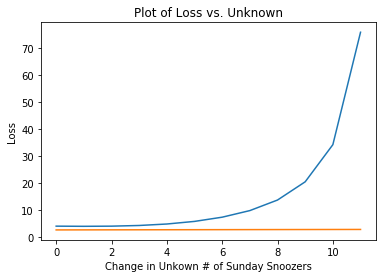

In [643]:

plt.plot(range(len(ES_List)), ES_List, label='label 1')
plt.plot(range(len(PR_List)), PR_List, label='label 2')
plt.title('Plot of Loss vs. Unknown')
plt.xlabel('Change in Unkown # of Sunday Snoozers')
plt.ylabel('Loss')
plt.show()

<br>

<a/ id='p2e'></a>

### (2e)

We might have enough information based on the plot of **2d** to make a decision, but let's dig one layer deeper. Those decisions we would make are affected, after all, by *what are our beliefs about $x$*?

Our beliefs about $x$ can be brought into the mix in the form of the ***prior distribution*** on $x$, $f(x)$. Here, $f(x)$ is discrete, so instead of specifying a probability distribution of some form, we can simply define the probability for each of the possible outcomes ($x=1, x=2, \ldots, x=12$). And then we just need to make sure they sum to 1 (since that's what a probability distribution is).

So the simplest (and often silliest) thing we could do is define **uniform** prior probability to each of the 12 possible outcomes for $x$:

In [644]:
x = list(range(1,13))
prior = [1]*12

Note that while each probability in `prior` is equal, they are not normalized! So let's normalize them:

In [661]:
norm = np.sum(prior)
prior = [prior[i]/norm for i in range(len(prior))]
print(prior)

[0.083333333333333329, 0.083333333333333329, 0.083333333333333329, 0.083333333333333329, 0.083333333333333329, 0.083333333333333329, 0.083333333333333329, 0.083333333333333329, 0.083333333333333329, 0.083333333333333329, 0.083333333333333329, 0.083333333333333329]


We now have the prior probability for each possible value of $x$ as well as the loss under each decision, $L(d_{ES},x)$ and $L(d_{PR},x)$. Use these to calculate the **expected value** of each decision's loss (with respect to $x$). Which decision is the Bayes' Decision?

[0.3481553119113957, 0.69148160615526133, 1.0396369180666571, 1.408658029415351, 1.8230457364207251, 2.3179173957261185, 2.9428753067668465, 3.7716507207775942, 4.9263512591568457, 6.643760630708937, 9.5076775642145517, 15.84180829551558]
[0.0067915491563344923, 0.013488897507040649, 0.020280446663375144, 0.027479029972905872, 0.035562590342721433, 0.045216170469928409, 0.057407374304133917, 0.073574495043765023, 0.096099515340581296, 0.12960143178244207, 0.18546854616532471, 0.30902995325144711]


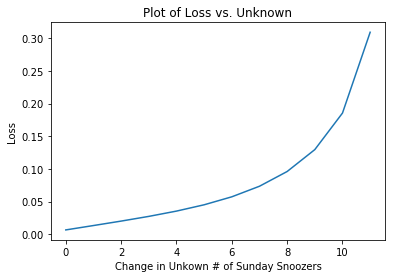

In [666]:
expected = 0
expected_value = []
for i in range(len(prior)):
    expected += prior[i]*ES_List[i]
    expected_value.append(expected)
print(expected_value)
normed = [i/sum(expected_value) for i in expected_value]
print(normed)

plt.plot(range(len(normed)), normed, label='label 2')
plt.title('Plot of Loss vs. Unknown')
plt.xlabel('Change in Unkown # of Sunday Snoozers')
plt.ylabel('Loss')
plt.show()



Now a uniform prior distribution is a nice first stab at this, but we probably have a better sense of how many people want to stay for Sunday night. At the very least, we should know that it's highly unlikely that $x=1$ or $x=12$. Revise the prior probabilities to reflect our judgment that it is more likely that moderate numbers of people stick around for Sunday night, and less likely that extremal numbers of people stay. As a guide, think about how much more likely it might be for 5 or 6 people (for example) to stay for the third night than it is for only 1 or all 12 to stay. Use this *odds ratio* to guide your selection of the relative prior probabilities, and be sure to check that your discrete prior probability distribution is properly normalized.

Now use this revised "informative" prior probability distribution to calculate $E_x[L(d_{ES},x)]$ and $E_x[L(d_{PR},x)]$, and determine what is the Bayes' Decision.

<br>

<a/ id='p2f'></a>

### (2f)

If the decision you make is not strongly affected by changes in the underlying assumptions, then your decision is said to be ***robust***. Was our decision robust against changing the underlying prior distribution $f(x)$?

What are at least **two** other places where making judgments/assumptions could possibly have affected our decision-making? Try changing one of them to see if making other judgments affects the outcome of this decision analysis. 

<br>

<a/ id='p2g'></a>

### (2g)

#### Expected value of perfect information

Unless we make some rather funky assumptions, we know that the **expected value of including uncertainty** (EVIU) is 0 for the quadratic loss  function. (One situation in which it is not is if we were a risk-averse decision-maker, and took as our central estimate for $x$ something besides $E_x[x]$. But we aren't getting into that here.) What about the **expected value of perfect information** regarding $x$, EVPI?

Recall that EVPI is defined as

$$\text{EVPI} = E_x[L(d_{Bayes},x)] - E_x[L(d_{pi},x)]$$

where $d_{Bayes}$ is the Bayes' Decision and $d_{pi}$ is the decision we would make if we had perfect information about $x$.

We know from **2e** what $d_{Bayes}$ is, and the associated expected loss under this decision. Use the one with a more *informative* prior (i.e., not the uniform prior).

But what about $d_{pi}$?

If we had perfect information about $x$, then we would always pick the decision that gives a lower loss (courtesy of our figure from **2d**). So:

$$L(d_{pi},x) = \min{[L(d_{ES}, x), L(d_{PR}, x)]}$$

In other words, for each possible value of $x$, the loss with perfect information is the minimum of the two losses.

Use this to calculate $E_x[L(d_{pi},x)]$ and EVPI using the more informative prior.  Then, recalculate EVPI using the uniform prior for $x$.

How does our certainty/uncertainty regarding $x$ affect the expected value of having perfect information about this quantity?

<br>

---

<a id='extra'></a>

## Extra cred (not credit)

What is the best route from the Engineering Center to the Ralphie statue between Muenzinger and Folsom Stadium?

<img src="http://drive.google.com/uc?export=view&id=1u25gItndw9-BSutPEQI-rNsc1E6wkZav" alt="Drawing" style="width: 550px;"/>